In [1]:
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from multiprocessing import Pool
from tqdm import tqdm 
import multiprocessing
from multiprocessing import Process, Manager
import datetime
from matplotlib import ticker

## No need to run

In [5]:
inputdir='../../Dataset/raw_conjunction_data/'
# col = [
#     "Max Probability", "Dilution Threshold(km)", "Min Range(km)", "Relative Velocity(km/sec)", "Days Since Epoch1",
#     "Days Since Epoch2","NAME1","NAME2","ID"]
col=["Max Probability","Min Range(km)","NAME1","NAME2","ID","TCA"]
df_empty=pd.DataFrame(columns=col)
for parents, dirnames, filenames in os.walk(inputdir):
    for filename in filenames:
        df=pd.read_excel(os.path.join(parents,filename))
        df=df[col]
        df_empty=df_empty.append(df,ignore_index=True)

In [7]:
len(df_empty)

4569296

In [8]:
# '''
# col = (
#     "Max Probability", "Dilution Threshold(km)", "Min Range(km)", "Relative Velocity(km/sec)", "Days Since Epoch1",
#     "Days Since Epoch2","NAME1","NAME2","ID")
# '''
# df = pd.read_excel('data/conjunction_result30000.xls')
data=df_empty.values
print(data[0])
print("距离:{}".format(data[0][2]))

[0.1951 0.004 'STARLINK-3282' 'STARLINK-3290' '50177-50828'
 '2022 Apr 24 01:27:25.613']
距离:STARLINK-3282


In [ ]:
#{'INTLDES': '1957-001A', 'NORAD_CAT_ID': '1', 'OBJECT_TYPE': 'ROCKET BODY', 'SATNAME': 'SL-1 R/B', 'COUNTRY': 'CIS', 'LAUNCH': '1957-10-04', 'SITE': 'TTMTR', 'DECAY': '1957-12-01', 'PERIOD': '96.19', 'INCLINATION': '65.10', 'APOGEE': '938', 'PERIGEE': '214', 'COMMENT': None, 'COMMENTCODE': '4', 'RCSVALUE': '0', 'RCS_SIZE': 'LARGE', 'FILE': '1', 'LAUNCH_YEAR': '1957', 'LAUNCH_NUM': '1', 'LAUNCH_PIECE': 'A', 'CURRENT': 'Y', 'OBJECT_NAME': 'SL-1 R/B', 'OBJECT_ID': '1957-001A', 'OBJECT_NUMBER': '1'}

## Start from this line

In [2]:
file="../Figure10/data/category.json"
category=[]
col_cate=['NORAD_CAT_ID','OBJECT_TYPE']
with open(file, 'r') as load_f:
        tmp=json.load(load_f)
        category=pd.DataFrame(tmp)
        category=category[col_cate]
category=category.values
category_dict={}
for item in category:
    category_dict[item[0]]=item[1]


In [11]:
# np.save("plot_distance_data.npy",data)

In [3]:
data=np.load("../Figure10/data/plot_distance_data.npy",allow_pickle=True)

In [4]:
#starlink-starlink, starlink-other satellites, starlink-debris, starlink-all
#根据类别分类
def classification(data):
    count=0
    result={'s-s':[],'s-o_s':[],'s-d':[],'s-u':[],'s-all':[]}
    for i in tqdm(range(len(data))) :
        item=data[i]
        id1,id2=item[4].split("-")
        id1=str(int(id1))
        id2=str(int(id2))
        try:
            # [type1]=category[category["NORAD_CAT_ID"]==id1]["OBJECT_TYPE"].values
            # [type2]=category[category["NORAD_CAT_ID"]==id2]["OBJECT_TYPE"].values
            type1=category_dict[id1]
            type2=category_dict[id2]
        except:
            count+=1
            print(item)
            continue
        if item[2].startswith('STARLINK') and not item[2].endswith('(DARKSAT)'):
            is_starlink1=True
        else:
            is_starlink1=False
        if item[3].startswith('STARLINK') and not item[3].endswith('(DARKSAT)'):
            is_starlink2=True
        else:
            is_starlink2=False
        if is_starlink1 and is_starlink2:
            result['s-s'].append(item[:2])
            result['s-all'].append(item[:2])
        elif is_starlink1:
            if type2=="PAYLOAD":
                result['s-o_s'].append(item[:2])
            elif type2=="DEBRIS" or type2=='ROCKET BODY':
                result['s-d'].append(item[:2])
            elif type2=='UNKNOWN':
                result['s-u'].append(item[:2])
            result['s-all'].append(item[:2])
        elif is_starlink2:
            if type1=="PAYLOAD":
                result['s-o_s'].append(item[:2])
            elif type1=="DEBRIS" or type1=='ROCKET BODY':
                result['s-d'].append(item[:2])
            elif type1=='UNKNOWN':
                result['s-u'].append(item[:2])
            result['s-all'].append(item[:2])
    print(len(result))
    print(count)
    for key,val in result.items():
        print(key+":"+str(len(val)))
    return result
result=classification(data)

100%|██████████| 4569296/4569296 [00:09<00:00, 464265.64it/s]

5
0
s-s:1041844
s-o_s:355624
s-d:448376
s-u:134574
s-all:1980418


In [4]:
for k,v in result.items():
    print(k)
    print(len(v))

s-s
1041780
s-o_s
355560
s-d
448312
s-u
134510
others
2588814


0
1
2
3
4


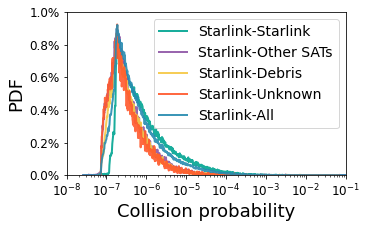

In [5]:
fig=plt.figure(1,(5,3))
# plt.subplots_adjust(wspace =0.3, hspace =0.5)#调整子图间距
# color=["#00A491","#FFCD43","#FF592D"]
color=["#00A491","#8E55A5","#F6C845","#FF592D","#278BB0"]
name=["Starlink-Starlink", "Starlink-Other SATs", "Starlink-Debris","Starlink-Unknown", "Starlink-All"]
i=0
for k,v_tmp in result.items():
    v=[item[0] for item in v_tmp]
    hist, bins = np.histogram(v, bins=1000)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    count, bins_count=np.histogram(v, bins=logbins,range=(0,1e-2))
    pdf = count / sum(count)
    print(i)
    plt.plot(bins_count[1:], pdf,color=color[i],lw=2,label=name[i],alpha=0.9)
    i=i+1
plt.xscale("log")
plt.xlabel("Collision probability", size=18)
def to_percent(temp, position):
    return '%0.01f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.ylabel("PDF",size=18)
plt.xlim(1e-8,1e-1)
plt.ylim(0,0.01)
plt.yticks(size=12)
plt.xticks(size=12)
# plt.ylim(0,0.008)
plt.legend(fontsize=14,title_fontsize=14)
#plt.savefig('figure20a.pdf')

In [6]:
total=[item[1]for item in result['s-all']]

<Figure size 360x216 with 0 Axes>

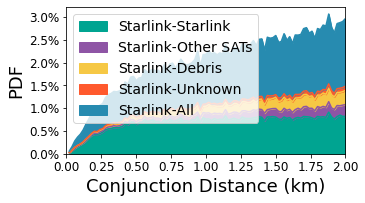

In [20]:
#巨型星座造成的
fig= plt.figure(1,(5,3))
plt.rcParams["figure.figsize"] = (5,2.7)
d={}

count_total, bins_count = np.histogram(total, bins=100,range=(0,2))
name=["Starlink-Starlink", "Starlink-Other SATs", "Starlink-Debris","Starlink-Unknown", "Starlink-All"]
i=0
for key,item_tmp in result.items():
    item=[item[1] for item in item_tmp]
    count, bins_count = np.histogram(item, bins=100,range=(0,2))
    pdf = count / sum(count_total)
    d[name[i]]=pd.Series(pdf, index=bins_count[1:])
    i=i+1
#     print(count) data
#     print(bins_count) index
df1 = pd.DataFrame(d)
#Greens_r
#"#00A491","#FFCD43","#FF592D"
#"#37A78F","#FFCD43","#287FD5"
df1.plot.area(color=["#00A491","#8E55A5","#F6C845","#FF592D","#278BB0"],alpha=1)
plt.xlim(0,2)
# plt.ylim(0,1)
def to_percent(temp, position):
    return '%0.01f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.xlabel("Conjunction Distance (km)",fontsize=18)
plt.ylabel("PDF",fontsize=18)
plt.yticks(size=12)
plt.xticks(size=12)
plt.legend(fontsize=14,title_fontsize=14)
#plt.savefig('figure20b.pdf')

In [8]:
#starlink-starlink, starlink-other satellites, starlink-debris, starlink-others,others
#根据类别分类
def classification_all(data):
    count=0
    result={'s-s':0,'s-o_s':0,'s-d':0,'s-u':0,'others':0}
    for i in tqdm(range(len(data))) :
        item=data[i]
        id1,id2=item[4].split("-")
        id1=str(int(id1))
        id2=str(int(id2))
        try:
            # [type1]=category[category["NORAD_CAT_ID"]==id1]["OBJECT_TYPE"].values
            # [type2]=category[category["NORAD_CAT_ID"]==id2]["OBJECT_TYPE"].values
            type1=category_dict[id1]
            type2=category_dict[id2]
        except:
            count+=1
            print(item)
            continue
        if item[2].startswith('STARLINK') and not item[2].endswith('(DARKSAT)'):
            is_starlink1=True
        else:
            is_starlink1=False
        if item[3].startswith('STARLINK') and not item[3].endswith('(DARKSAT)'):
            is_starlink2=True
        else:
            is_starlink2=False
        if is_starlink1 and is_starlink2:
            result['s-s']+=1
        elif is_starlink1:
            if type2=="PAYLOAD":
                result['s-o_s']+=1
            elif type2=="DEBRIS" or type2=='ROCKET BODY':
                result['s-d']+=1
            else:
                result['s-u']+=1
        elif is_starlink2:
            if type1=="PAYLOAD":
                result['s-o_s']+=1
            elif type1=="DEBRIS" or type1=='ROCKET BODY':
                result['s-d']+=1
            else:
                result['s-u']+=1
        else:
            result['others']+=1
            
    print(len(result))
    print(count)
    for key,val in result.items():
        print(key+":"+str(val))
    return result
proportion=classification_all(data)

100%|██████████| 4569296/4569296 [00:09<00:00, 507103.93it/s]


5
0
s-s:1041844
s-o_s:355624
s-d:448376
s-u:134574
others:2588878


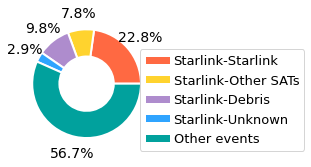

In [22]:
colors=["#FF6942","#FFD32E","#AE8CCD","#2FA4FF","#01A19D"]
label=["Starlink-Starlink", "Starlink-Other SATs", "Starlink-Debris", "Starlink-Unknown","Other events"]
fig=plt.figure(1,(5,2.5))
plt.pie(proportion.values(),colors=colors,autopct="%0.1f%%",wedgeprops = {'width':0.5,'edgecolor':'white', 'linewidth':2},startangle=0,pctdistance=1.3,textprops={'fontsize':14,'weight': 'normal'})
plt.legend(label,loc='upper right', bbox_to_anchor=(2.15, 0.8),fontsize=13,handletextpad=0.2)
# plt.tight_layout()
plt.savefig('figure10a.pdf')

In [9]:
def judge_type(item):
    id1,id2=item[2].split("-")
    id1=str(int(id1))
    id2=str(int(id2))
    type1=category_dict[id1]
    type2=category_dict[id2]
    if item[0].startswith('STARLINK') and not item[0].endswith('(DARKSAT)'):
        is_starlink1=True
    else:
        is_starlink1=False
    if item[1].startswith('STARLINK') and not item[1].endswith('(DARKSAT)'):
        is_starlink2=True
    else:
        is_starlink2=False
    if is_starlink1 and is_starlink2:
        return 's-s'
    elif is_starlink1:
        if type2=="PAYLOAD":
            return 's-o_s'
        elif type2=="DEBRIS"or type2=='ROCKET BODY':
            return's-d'
        else:
            return 's-u'
    elif is_starlink2:
        if type1=="PAYLOAD":
            return's-o_s'
        elif type1=="DEBRIS"or type1=='ROCKET BODY':
            return's-d'
        else:
            return's-u'
    else:
        return'others'
        

In [10]:
def standardize_time(str1):
    str1=str1.split(' ')
    if str1[1]=='Apr':
        str1[1]='4'
    elif str1[1]=='May':
        str1[1]='5'
    elif str1[1]=='Jun':
        str1[1]='6'
    return str1[0]+"-"+str1[1]+"-"+str1[2]+" "+str1[3][:-4]
print(standardize_time('2022 Apr 28 07:20:57.500'))

2022-4-28 07:20:57


## No need to run

In [25]:
inputdir='../../Dataset/raw_conjunction_data/'
col=["NAME1","NAME2","ID","TCA"]
result={'s-s':[],'s-o_s':[],'s-d':[],'s-u':[],'others':[]}
for parents, dirnames, filenames in os.walk(inputdir):
    for i in tqdm(range(len(filenames))):
        filename=filenames[i]
        df=pd.read_excel(os.path.join(parents,filename))
        df=df[col].values
        tmp_result={'s-s':[],'s-o_s':[],'s-d':[],'s-u':[],'others':[]}
        for item in df:
            tt=datetime.datetime.strptime(standardize_time(item[3]),"%Y-%m-%d %H:%M:%S")
            tmp_result[judge_type(item[:3])].append(tt)
        for k,v in tmp_result.items():
            v=sorted(v)
            for t in range(len(v)-1):
                result[k].append(v[t+1]-v[t])
np.save("frequency_conjunction.npy",result)

100%|██████████| 64/64 [15:18<00:00, 15.31s/it]


## Start from this line

In [26]:
result=np.load("./data/frequency_conjunction.npy",allow_pickle=True)
result=result.item()
for k,v in result.items():
    print(k)
    v=[item.total_seconds()/60 for item in v]
    result[k]=v
    print(v[0])

s-s
8.283333333333333
s-o_s
0.4666666666666667
s-d
1.8666666666666667
s-u
14.933333333333334
others
0.03333333333333333


In [28]:
# np.save('result.npy',result)

In [31]:
result = np.load('./data/result.npy',allow_pickle=True).item()

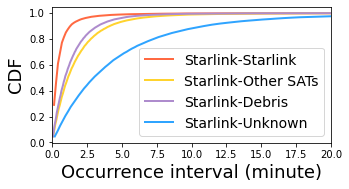

In [32]:
fig=plt.figure(1,(5,2.5))
colors=["#FF6942","#FFD32E","#AE8CCD","#2FA4FF","#01A19D"]
ls=['--','-']
label=["Starlink-Starlink", "Starlink-Other SATs", "Starlink-Debris", "Starlink-Unknown","Other events"]
i=0
for k,v_tmp in result.items():
    if k=='others':
        continue
    hist, bins_range = np.histogram(v_tmp, bins=1000)
    pdf = hist / sum(hist)
    cdf=np.cumsum(pdf)
    plt.plot(bins_range[1:], cdf,color=colors[i],lw=2,label=label[i],alpha=1)
    i=i+1
plt.xlabel("Occurrence interval (minute)", size=18)
plt.ylabel("CDF",size=18)
plt.xlim(left=0,right=20)
plt.legend(fontsize=14,title_fontsize=14)
plt.savefig('figure10b.pdf')